In [1]:
import json
import re
import pandas as pd
import numpy as np
from rdkit import Chem
from tqdm import tqdm
from matchms.importing import load_from_mgf
from matchms.exporting import save_as_mgf

### Standardize SMILES

31555


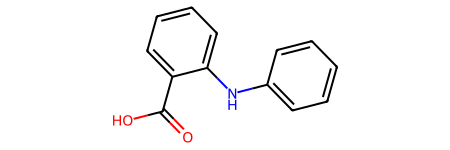

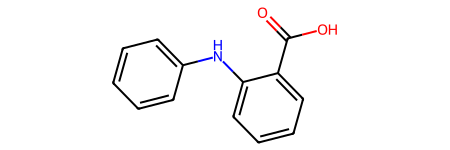

In [2]:
with open('../data/all_smiles.json', 'r') as f:
    smiles_in = json.load(f)
print(len(smiles_in))
with open('../data/all_smiles_standardized_mces/all_smiles_standardized.json', 'r') as f:
    smiles_out = json.load(f)
len(smiles_out)

std_smiles_map = {}
for k, v in smiles_in.items():
    for i, s in enumerate(v):
        std_smiles_map[s] = smiles_out[k][i]
len(std_smiles_map)
s = list(std_smiles_map.keys())[13112]
display(Chem.MolFromSmiles(s))
display(Chem.MolFromSmiles(std_smiles_map[s]))

In [3]:
spectra = list(load_from_mgf('../data/cleaned_libraries_4.mgf'))
print(len(spectra))
spectra[0].metadata

414174


{'smiles': 'CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC',
 'inchi': 'InChI=1S/C16H17NO4/c1-11(18)17-14(8-12-6-4-3-5-7-12)15-9-13(20-2)10-16(19)21-15/h3-7,9-10,14H,8H2,1-2H3,(H,17,18)/t14-/m0/s1',
 'inchikey': 'VFMQMACUYWGDOJ-AWEZNQCLSA-N',
 'precursor_mz': 288.1225,
 'adduct': '[M+H]+',
 'parent_mass': '287.115224',
 'formula': 'C16H17NO4',
 'precursor_formula': 'C16H18NO4',
 'instrument_type': 'LC-ESI-ITFT',
 'collision_energy': '30(NCE)',
 'identifier': 'MassSpecGymID0000001'}

### Standardize collision energies

In [4]:
# Code from Adamo: https://github.com/pluskal-lab/MassSpecGym/blob/8c6514cbbc2804ff57b5e9e39fe010a9d2ca310b/notebooks/simulation_preproc.ipynb.

def parse_ce_str(ce_str):

    ce_str = str(ce_str)
    normal_regex = re.compile(r'\d+(\.\d+)?')
    # ramped_regex = re.compile(r'\d+(\.\d+)?-\d+(\.\d+)?')
    ramped_regex = re.compile(r'\d+(\.\d+)?(V)?(-|->)\d+(\.\d+)?(V)?')
    ce_str = ce_str.split(";")[-1]
    try:
        if "%" in ce_str:
            normalized = True
        else:
            normalized = False
        if "-" in ce_str or "Ramp" in ce_str or "RAMP" in ce_str or "->" in ce_str:
            ramped = True
            ramped_ce = ramped_regex.search(ce_str).group(0)
            if "->" in ramped_ce:
                min_ce, max_ce = ramped_ce.split("->")
            else:
                min_ce, max_ce = ramped_ce.split("-")
            ce = 0.5*float(min_ce.strip("V")) + 0.5*float(max_ce.strip("V"))
        else:
            ramped = False
            ce = normal_regex.search(ce_str).group(0)
            ce = float(ce)
    except:
        ce = np.nan
        normalized = False
        ramped = False
    return ce, normalized, ramped

def convert_nce(row):
    # assumes charge factor of 1
    if row["normalized"]:
        nce = row["ce"]
        ace = (nce * row["precursor_mz"] * 1.) / 500.
    else:
        ace = row["ce"]
    return ace

In [5]:
ce_df = pd.DataFrame({
    "ce": [s.get('collision_energy') for s in tqdm(spectra)],
    "precursor_mz": [s.get('precursor_mz') for s in tqdm(spectra)]
})
print(ce_df['ce'].isna().sum())
ce_df["ce"], ce_df["normalized"], ce_df["ramped"] = zip(*ce_df["ce"].apply(parse_ce_str))
ce_df["ce"] = ce_df.apply(convert_nce, axis=1)
print(ce_df['ce'].isna().sum())
ce_df["ce_str"] = ce_df.apply(
    lambda row: f'{row["ce"]} (normalized={row["normalized"]}, ramped={row["ramped"]})'
                if not pd.isnull(row["ce"])
                else row["ce"],
    axis=1
)
ce_df

100%|██████████| 414174/414174 [00:04<00:00, 93651.51it/s]


272296
272690


,ce,precursor_mz,normalized,ramped,ce_str
0,30.0,288.1225,False,False,"30.0 (normalized=False, ramped=False)"
1,20.0,288.1225,False,False,"20.0 (normalized=False, ramped=False)"
2,40.0,288.1225,False,False,"40.0 (normalized=False, ramped=False)"
3,55.0,288.1225,False,False,"55.0 (normalized=False, ramped=False)"
4,10.0,288.1225,False,False,"10.0 (normalized=False, ramped=False)"
...,...,...,...,...,...
414169,NaN,1225.7400,False,False,NaN
414170,NaN,479.1230,False,False,NaN
414171,NaN,478.3250,False,False,NaN
414172,NaN,478.3250,False,False,NaN


### Standardize instruments

In [6]:
def standardize_instrument_type(instr):
    if instr.startswith("LC-"):
        instr = instr[3:]
    if instr.startswith("ESI-"):
        instr = instr[4:]
    if instr.startswith("Q-"):
        instr = instr[2:]
    if instr.endswith("/MS"):
        instr = instr[:-3]
    if instr in ['Q Exactive Focus Hybrid Quadrupole Orbitrap Mass Spectrometer (Thermo Fisher Scientific)', 'QEHF']:
        instr = 'Orbitrap'
    if instr in ['TOF', 'ITTOF']:
        instr = 'QTOF'
    if instr in ['FT']:
        instr = 'QFT'
    return instr

### Apply all the processing steps

In [7]:
spectra_new = []
num_failed = 0
for i, spec in enumerate(tqdm(spectra)):
    spec_new = spec.clone()
    try:
        spec_new.set('smiles', std_smiles_map[spec.get('smiles')])
    except:
        # print(f"Failed to find standardized SMILES for spectrum {i}")
        num_failed += 1
        continue
    if 'collision_energy' in spec.metadata.keys():
        spec_new.set('collision_energy', ce_df['ce_str'].iloc[i])
    if 'instrument_type' in spec.metadata.keys():
        spec_new.set('instrument_type', standardize_instrument_type(spec.get('instrument_type')))
    spectra_new.append(spec_new)
print(len(spectra_new))
print('Num. failed', num_failed)
spectra_new[3].metadata

100%|██████████| 414174/414174 [01:16<00:00, 5395.99it/s]

414049
Num. failed 125


{'smiles': 'CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC',
 'inchi': 'InChI=1S/C16H17NO4/c1-11(18)17-14(8-12-6-4-3-5-7-12)15-9-13(20-2)10-16(19)21-15/h3-7,9-10,14H,8H2,1-2H3,(H,17,18)/t14-/m0/s1',
 'inchikey': 'VFMQMACUYWGDOJ-AWEZNQCLSA-N',
 'precursor_mz': 288.1225,
 'adduct': '[M+H]+',
 'parent_mass': '287.115224',
 'formula': 'C16H17NO4',
 'precursor_formula': 'C16H18NO4',
 'instrument_type': 'ITFT',
 'collision_energy': '55.0 (normalized=False, ramped=False)',
 'identifier': 'MassSpecGymID0000004'}

### Drop empty spectra

In [8]:
print(len(spectra_new))
spectra_new = [s for s in tqdm(spectra_new) if len(s.peaks) > 0]
print(len(spectra_new))

414049


100%|██████████| 414049/414049 [00:01<00:00, 248226.21it/s]

414049


### Convert to `.tsv`

In [9]:
df = []
for s in tqdm(spectra_new):
    row = {
        'mzs': ','.join([str(m) for m in s.peaks.mz]),
        'intensities': ','.join([str(m) for m in s.peaks.intensities])
    }
    row.update(s.metadata)
    df.append(row)
df = pd.DataFrame(df)
df

100%|██████████| 414049/414049 [00:20<00:00, 19752.94it/s]


,mzs,intensities,smiles,inchi,inchikey,precursor_mz,adduct,parent_mass,formula,precursor_formula,instrument_type,collision_energy,identifier
0,"91.0542,125.0233,154.0499,155.0577,185.0961,20...","0.24524524524524524,1.0,0.08008008008008008,0....",CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC,InChI=1S/C16H17NO4/c1-11(18)17-14(8-12-6-4-3-5...,VFMQMACUYWGDOJ-AWEZNQCLSA-N,288.1225,[M+H]+,287.115224,C16H17NO4,C16H18NO4,ITFT,"30.0 (normalized=False, ramped=False)",MassSpecGymID0000001
1,"91.0542,125.0233,155.0577,185.0961,229.0859,24...","0.0990990990990991,0.28128128128128127,0.04004...",CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC,InChI=1S/C16H17NO4/c1-11(18)17-14(8-12-6-4-3-5...,VFMQMACUYWGDOJ-AWEZNQCLSA-N,288.1225,[M+H]+,287.115224,C16H17NO4,C16H18NO4,ITFT,"20.0 (normalized=False, ramped=False)",MassSpecGymID0000002
2,"69.0343,91.0542,125.0233,127.039,153.0699,154....","0.03403403403403404,0.31431431431431434,1.0,0....",CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC,InChI=1S/C16H17NO4/c1-11(18)17-14(8-12-6-4-3-5...,VFMQMACUYWGDOJ-AWEZNQCLSA-N,288.1225,[M+H]+,287.115224,C16H17NO4,C16H18NO4,ITFT,"40.0 (normalized=False, ramped=False)",MassSpecGymID0000003
3,"69.0343,91.0542,110.06,111.0441,112.0393,120.0...","0.17917917917917917,0.47347347347347346,0.0380...",CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC,InChI=1S/C16H17NO4/c1-11(18)17-14(8-12-6-4-3-5...,VFMQMACUYWGDOJ-AWEZNQCLSA-N,288.1225,[M+H]+,287.115224,C16H17NO4,C16H18NO4,ITFT,"55.0 (normalized=False, ramped=False)",MassSpecGymID0000004
4,"91.0542,125.0233,185.0961,229.0859,246.1125,28...","0.07807807807807808,0.1841841841841842,0.03503...",CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC,InChI=1S/C16H17NO4/c1-11(18)17-14(8-12-6-4-3-5...,VFMQMACUYWGDOJ-AWEZNQCLSA-N,288.1225,[M+H]+,287.115224,C16H17NO4,C16H18NO4,ITFT,"10.0 (normalized=False, ramped=False)",MassSpecGymID0000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
414044,"77.5606,85.238739,152.079361,156.231537,189.96...","0.00022242662384734551,0.0007871876908597226,0...",CCC(C)CCCCC(=O)N[C@@H](CCN)C(=O)N[C@@H]([C@@H]...,InChI=1S/C56H98N16O13/c1-7-32(4)13-11-12-16-44...,WQVJHHACXVLGBL-BPJDFBQWSA-N,1225.7400,[M+Na]+,1202.750782,C56H98N16O13,C56H98N16NaO13,QTOF,NaN,MassSpecGymID0414170
414045,"72.043739,86.060242,98.058304,99.0634,126.0537...","0.0019527744563354998,0.0016939927337585416,0....",C[C@@]1([C@H]2C[C@H]3[C@@H](C(=O)C(=C([C@]3(C(...,InChI=1S/C22H23ClN2O8/c1-21(32)7-6-8-15(25(2)3...,CYDMQBQPVICBEU-XRNKAMNCSA-N,479.1230,[M+H]+,478.115724,C22H23ClN2O8,C22H24ClN2O8,QTOF,NaN,MassSpecGymID0414171
414046,"72.080132,102.233917,113.082344,113.121498,114...","0.021173783463613503,0.007516001055215398,0.03...",C[C@H]([C@@H]1CC[C@H]([C@H](O1)O[C@@H]2[C@H](C...,InChI=1S/C21H43N5O7/c1-9(25-3)13-6-5-10(22)19(...,CEAZRRDELHUEMR-CAMVTXANSA-N,478.3250,[M+H]+,477.317724,C21H43N5O7,C21H44N5O7,QTOF,NaN,MassSpecGymID0414172
414047,"55.053627,56.455425,58.065819,67.053543,82.065...","0.031731527156456024,0.017878400151027027,0.07...",C[C@H]([C@@H]1CC[C@H]([C@H](O1)O[C@@H]2[C@H](C...,InChI=1S/C21H43N5O7/c1-9(25-3)13-6-5-10(22)19(...,CEAZRRDELHUEMR-CAMVTXANSA-N,478.3250,[M+H]+,477.317724,C21H43N5O7,C21H44N5O7,QTOF,NaN,MassSpecGymID0414173


### Double-check the validity of the SMILES standardization in the final `.tsv`

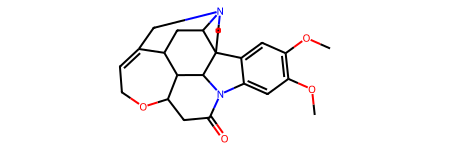

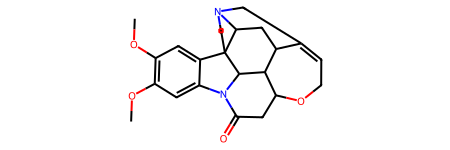

In [10]:
df_ = df.sample(1)
display(Chem.MolFromInchi(df_['inchi'].values[0]))
display(Chem.MolFromSmiles(df_['smiles'].values[0]))

In [11]:
df.to_csv('../data/data/MassSpecGym.tsv', index=False, sep='\t')

In [12]:
save_as_mgf(spectra_new, '../data/data/auxiliary/MassSpecGym.mgf')